In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import seaborn as sns  
from matplotlib.ticker import MaxNLocator, FuncFormatter, MultipleLocator
import matplotlib.ticker as ticker
import palettable 

type_colors = {'all':'k','main':'#fc8d62','asso':'#66c2a5','new':'grey'}

In [3]:
key_data = pd.read_csv('Key_Data.csv')

#### Overall topic contribution

In [4]:
target_info = key_data[['mentee_id','mentor_id','community','type','credit_mte','total_credit_mte']]
target_info.loc[:,'credit_ratio_mte'] = target_info['credit_mte']/target_info['total_credit_mte']

/var/folders/8n/d3_ymw7s7tn0tz9t554ghv5m0000gn/T/ipykernel_58575/500736206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_info.loc[:,'credit_ratio_mte'] = target_info['credit_mte']/target_info['total_credit_mte']


In [5]:
def type_count(tp_df):
    num_new = len(tp_df[tp_df.type=='new'])
    
    return num_new

num_new = target_info.groupby(['mentee_id','mentor_id']).apply(type_count).reset_index(name='num_new')
mentee_with_new = list(set(num_new['mentee_id'][num_new.num_new>0]))
mentee_without_new = list(set(num_new['mentee_id'][num_new.num_new==0]))

In [6]:
def topic_contri(tp_df):
    contri_main = np.sum(tp_df['credit_ratio_mte'][tp_df.type=='main'])
    contri_asso = np.sum(tp_df['credit_ratio_mte'][tp_df.type=='associate'])
    contri_new = np.sum(tp_df['credit_ratio_mte'][tp_df.type=='new'])
    
    return contri_main,contri_asso,contri_new

In [7]:
topic_contri_ratio = target_info.groupby(['mentee_id','mentor_id']).apply(topic_contri).reset_index(name='topic_contri_ratio')

df_list = []
tp_array = topic_contri_ratio.values
for k in tp_array:
    tp_k = [k[0],k[1]]
    tp_k.extend(list(k[2]))
    df_list.append(tp_k)

topic_contri_ratio = pd.DataFrame(df_list,columns=['mentee_id','mentor_id','main','asso','new'])

In [8]:
topic_contri_ratio.head(5)

,mentee_id,mentor_id,main,asso,new
0,A100066398,A1586848664,0.211043,0.029984,0.758973
1,A1002422011,A1897971127,0.606829,0.393171,0.000000
2,A1002422011,A1966502692,0.017778,0.982222,0.000000
3,A1003022340,A2157150214,1.000000,0.000000,0.000000
4,A100328954,A1993268291,0.000000,0.019098,0.980902


#### triangle axis plot

In [9]:
q10,q25,q50,q75,q95 = key_data['total_cits5_mte'].drop_duplicates().quantile([.1,.25,.5,.75,.95])
elites = key_data[['mentee_id','mentor_id']][(key_data.total_cits5_mte>=q95)&(key_data.total_credit_mte>=key_data.total_credit_mto)].drop_duplicates().values[:,0]
uses_raw_normal = topic_contri_ratio[(topic_contri_ratio.new<=1)
                                    &(~topic_contri_ratio['mentee_id'].isin(elites))][['main','asso','new']].values
# print(len(uses_raw_normal))

mentee_normal = topic_contri_ratio[(topic_contri_ratio.new<=1)
                                    &(~topic_contri_ratio['mentee_id'].isin(elites))][['mentee_id','mentor_id']]

cits5_mentee_normal = key_data[['mentee_id','total_cits5_mte']][key_data.mentee_id.isin(mentee_normal.mentee_id)].drop_duplicates()
mentee_normal = mentee_normal.merge(cits5_mentee_normal,on='mentee_id',how='left')
uses_raw_normal_size = np.array(list(mentee_normal['total_cits5_mte']))
# len(uses_raw_normal_size)

In [10]:
uses_raw_elites = topic_contri_ratio[(topic_contri_ratio.new<=1)
                             &(topic_contri_ratio['mentee_id'].isin(elites))][['main','asso','new']].values
# print(len(uses_raw_elites))
mentee_normal = topic_contri_ratio[(topic_contri_ratio.new<=1)
                                    &(topic_contri_ratio['mentee_id'].isin(elites))][['mentee_id','mentor_id']]

cits5_mentee_normal = key_data[['mentee_id','total_cits5_mte']][key_data.mentee_id.isin(mentee_normal.mentee_id)].drop_duplicates()
mentee_normal = mentee_normal.merge(cits5_mentee_normal,on='mentee_id',how='left')
uses_raw_elites_size = np.array(list(mentee_normal['total_cits5_mte']))

# print(len(uses_raw_elites_size))

/var/folders/8n/d3_ymw7s7tn0tz9t554ghv5m0000gn/T/ipykernel_58575/2702335869.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,1,1,aspect='equal', adjustable='box')
/var/folders/8n/d3_ymw7s7tn0tz9t554ghv5m0000gn/T/ipykernel_58575/2702335869.py:7: RuntimeWarning: invalid value encountered in scalar divide
  u_sum, gov, news, patent = sum(u),u[0]/sum(u),u[1]/sum(u),u[2]/sum(u)


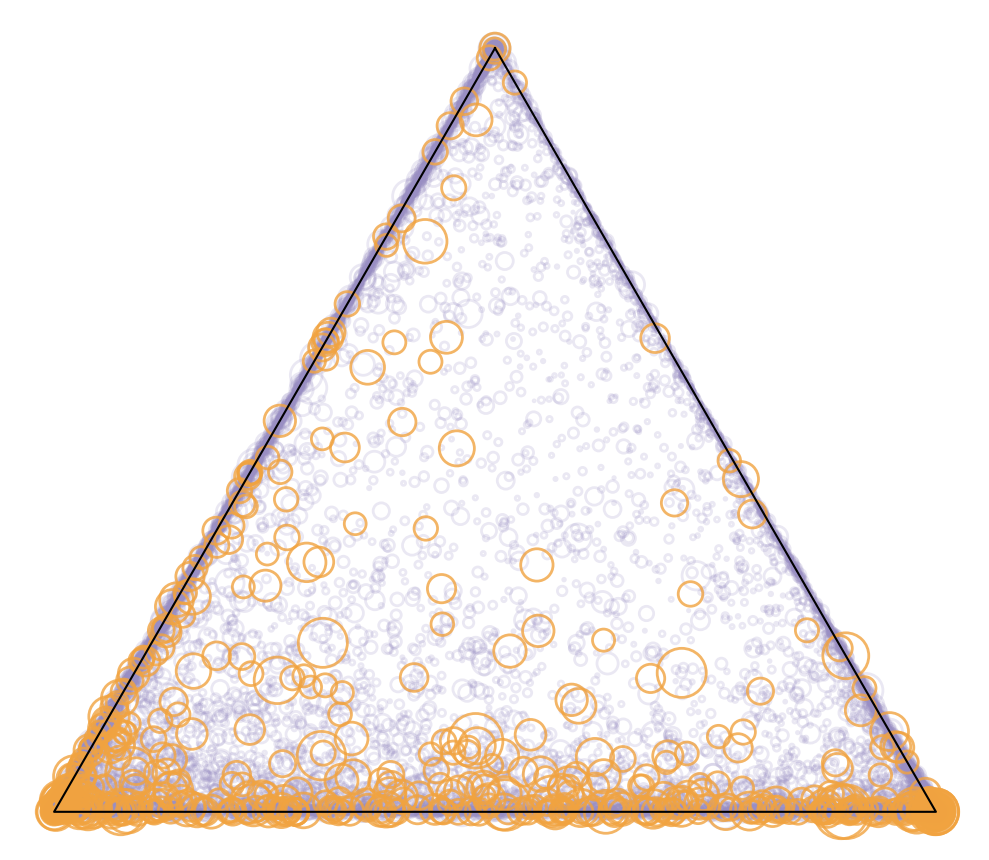

In [11]:
fig,axes = plt.subplots(1,1,figsize=(10,10))
plt.subplot(1,1,1,aspect='equal', adjustable='box')

# overall
i = 0
for u in uses_raw_normal[:25000]:  # only 25,000 data points selected, which is less than half of the actual total
    u_sum, gov, news, patent = sum(u),u[0]/sum(u),u[1]/sum(u),u[2]/sum(u)
    xloc = (1.0 - gov - 2*news)*3**(-.5)
    yloc = gov - 1.0/3
    point_size = uses_raw_normal_size[i]
    i+=1
    plt.scatter([xloc],[yloc],facecolors='none',edgecolors='#998ec3',alpha=0.2,s=point_size/100,lw=2)

# elite
i = 0    
for u in uses_raw_elites:
    u_sum, gov, news, patent = sum(u),u[0]/sum(u),u[1]/sum(u),u[2]/sum(u)
    xloc = (1.0 - gov - 2*news)*3**(-.5)
    yloc = gov - 1.0/3
    point_size = uses_raw_elites_size[i]
    i+=1
    plt.scatter([xloc],[yloc],facecolors='none',edgecolors='#f1a340',alpha=0.8,s=point_size/100,lw=2)
    
plt.plot([0,-3**(-.5),3**(-.5),0],[2.0/3,-1.0/3,-1.0/3,2.0/3],color='k')
plt.axis('off')
plt.tight_layout()

# fig.savefig('result_data_plot/new_plot/triangle plot(the average ratio of Credit).png',dpi=300)

In [12]:
# fig,axes = plt.subplots(1,1,figsize=(10,10))
# plt.subplot(1,1,1,aspect='equal', adjustable='box')

# # overall
# i = 0
# for u in uses_raw_normal[:25000]:  # only 25,000 data points selected, which is less than half of the actual total
#     u_sum, gov, news, patent = sum(u),u[0]/sum(u),u[1]/sum(u),u[2]/sum(u)
#     xloc = (1.0 - gov - 2*news)*3**(-.5)
#     yloc = gov - 1.0/3
#     point_size = uses_raw_normal_size[i]
#     i+=1
#     plt.scatter([xloc],[yloc],facecolors='none',edgecolors='#998ec3',alpha=0.2,s=point_size/100,lw=2)
  
# # elite
# i = 0    
# for u in uses_raw_elites:
#     u_sum, gov, news, patent = sum(u),u[0]/sum(u),u[1]/sum(u),u[2]/sum(u)
#     xloc = (1.0 - gov - 2*news)*3**(-.5)
#     yloc = gov - 1.0/3
#     point_size = uses_raw_elites_size[i]
#     i+=1
#     plt.scatter([xloc],[yloc],facecolors='none',edgecolors='#f1a340',alpha=0.8,s=point_size/100,lw=2)
    
# plt.plot([0,-3**(-.5),3**(-.5),0],[2.0/3,-1.0/3,-1.0/3,2.0/3],color='k')
# plt.axis('off')
# plt.tight_layout()


In [13]:
key_data = pd.read_csv('Key_Data.csv')

In [14]:
key_data.columns

Index(['index_i', 'mentee_id', 'mentor_id', 'community', 'paper_num_mte',
       'paper_num_mto', 'paper_ratio_mte', 'paper_ratio_mto', 'credit_mte',
       'credit_mto', 'communitys_paper_num_mto', 'communitys_paper_num_mte',
       'total_credit_mte', 'total_credit_mto', 'type', 'total_cits_mte',
       'total_cits_mto', 'total_cits5_mte', 'total_cits5_mto', 'cits_mte',
       'cits_mto', 'cits5_mte', 'cits5_mto', 'birthYear_mte', 'birthYear_mto'],
      dtype='object')

In [15]:
key_data['paper_ratio_mte'] = key_data['paper_num_mte']/key_data['communitys_paper_num_mte']

In [16]:
target_info = key_data[['mentee_id','mentor_id','community','type','paper_ratio_mte','paper_num_mte','communitys_paper_num_mte']][key_data.paper_num_mte>0]

In [17]:
target_info.head(5)

,mentee_id,mentor_id,community,type,paper_ratio_mte,paper_num_mte,communitys_paper_num_mte
2,A1964335128,A177689540,6.0,new,0.373134,25,67
4,A1964335128,A177689540,0.0,main,0.119403,8,67
5,A1964335128,A177689540,4.0,new,0.507463,34,67
7,A2047598244,A2124458367,5.0,associate,0.275000,11,40
9,A2047598244,A2124458367,3.0,associate,0.550000,22,40


In [18]:
def type_count(tp_df):
    num_new = len(tp_df[tp_df.type=='new'])
    
    return num_new

num_new = target_info.groupby(['mentee_id','mentor_id']).apply(type_count).reset_index(name='num_new')

In [19]:
num_new.head(5)

,mentee_id,mentor_id,num_new
0,A100066398,A1586848664,1
1,A1002422011,A1897971127,0
2,A1002422011,A1966502692,0
3,A1003022340,A2157150214,0
4,A100328954,A1993268291,3


In [20]:
mentee_with_new = list(set(num_new['mentee_id'][num_new.num_new>0]))
mentee_without_new = list(set(num_new['mentee_id'][num_new.num_new==0]))

In [21]:
def paper_contri(tp_df):
    contri_main = np.sum(tp_df['paper_ratio_mte'][tp_df.type=='main'])
    contri_asso = np.sum(tp_df['paper_ratio_mte'][tp_df.type=='associate'])
    contri_new = np.sum(tp_df['paper_ratio_mte'][tp_df.type=='new'])
    
    return contri_main,contri_asso,contri_new

In [22]:
paper_contri_ratio = target_info.groupby(['mentee_id','mentor_id']).apply(paper_contri).reset_index(name='paper_contri_ratio')

In [23]:
paper_contri_ratio.head(5)

,mentee_id,mentor_id,paper_contri_ratio
0,A100066398,A1586848664,"(0.21428571428571427, 0.07142857142857142, 0.7..."
1,A1002422011,A1897971127,"(0.4158415841584158, 0.5841584158415841, 0.0)"
2,A1002422011,A1966502692,"(0.04, 0.96, 0.0)"
3,A1003022340,A2157150214,"(1.0, 0.0, 0.0)"
4,A100328954,A1993268291,"(0.0, 0.049019607843137254, 0.9509803921568627)"


In [24]:
df_list = []
tp_array = paper_contri_ratio.values
for k in tp_array:
    tp_k = [k[0],k[1]]
    tp_k.extend(list(k[2]))
    df_list.append(tp_k)

In [25]:
paper_contri_ratio = pd.DataFrame(df_list,columns=['mentee_id','mentor_id','main','asso','new'])

In [26]:
paper_contri_ratio['total_contri'] = paper_contri_ratio['main'] + paper_contri_ratio['asso'] + paper_contri_ratio['new']

In [27]:
paper_contri_ratio.head(5)

,mentee_id,mentor_id,main,asso,new,total_contri
0,A100066398,A1586848664,0.214286,0.071429,0.714286,1.0
1,A1002422011,A1897971127,0.415842,0.584158,0.000000,1.0
2,A1002422011,A1966502692,0.040000,0.960000,0.000000,1.0
3,A1003022340,A2157150214,1.000000,0.000000,0.000000,1.0
4,A100328954,A1993268291,0.000000,0.049020,0.950980,1.0


In [28]:
len(paper_contri_ratio)

48504

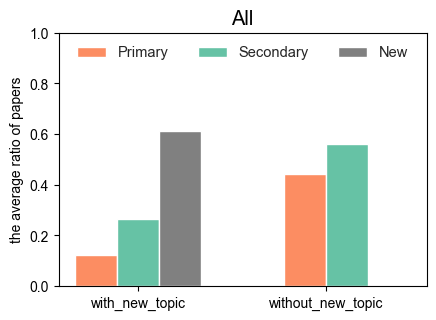

In [29]:
#with_new
data_with_new = paper_contri_ratio[(paper_contri_ratio['mentee_id'].isin(mentee_with_new))&(paper_contri_ratio.new<1)&(paper_contri_ratio.new>0)]

#without_new
data_without_new = paper_contri_ratio[(paper_contri_ratio['mentee_id'].isin(mentee_without_new))&(paper_contri_ratio.new==0)]

data_tp = data_with_new
mean_main_with_new = np.mean(data_tp['main'])
mean_asso_with_new = np.mean(data_tp['asso'])
mean_new_with_new = np.mean(data_tp['new'])

data_tp = data_without_new
mean_main_without_new = np.mean(data_tp['main'])
mean_asso_without_new = np.mean(data_tp['asso'])
mean_new_without_new = np.mean(data_tp['new'])


classes = ['with_new_topic','without_new_topic']
width = 0.3  # the width of the bars: can also be len(x) sequence

#figure layout set
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=[0.85*5,0.618*5])
sns.set(style='ticks',font_scale=1.2, font='Arial')

#plot
x_main = np.array([1,1+5*width])
ax.bar(x_main, [mean_main_with_new,mean_main_without_new], width,color=type_colors['main'],label='Primary')

x_associate = np.array([1+width,1+6*width])
ax.bar(x_associate, [mean_asso_with_new,mean_asso_without_new], width,color=type_colors['asso'],label='Secondary')

x_new = np.array([1+2*width,1+7*width])
ax.bar(x_new, [mean_new_with_new,mean_new_without_new], width,color=type_colors['new'],label='New')

#fig ticks set
ax.legend(frameon=0,ncol=3,loc='upper center',fontsize=10.5)
ax.set_ylim([0,1])
ax.set_ylabel('the average ratio of papers')
ax.set_xticks([1+width,1+5.5*width], classes)
ax.set_title(f'All')
# fig.savefig('result_data_plot/All (the average ratio of papers).pdf')
plt.show()

##### triangle plot

In [30]:
paper_contri_ratio.head(5)

,mentee_id,mentor_id,main,asso,new,total_contri
0,A100066398,A1586848664,0.214286,0.071429,0.714286,1.0
1,A1002422011,A1897971127,0.415842,0.584158,0.000000,1.0
2,A1002422011,A1966502692,0.040000,0.960000,0.000000,1.0
3,A1003022340,A2157150214,1.000000,0.000000,0.000000,1.0
4,A100328954,A1993268291,0.000000,0.049020,0.950980,1.0


In [31]:
q10,q25,q50,q75,q95 = key_data['total_cits5_mte'].drop_duplicates().quantile([.1,.25,.5,.75,.95])
elites = key_data[['mentee_id','mentor_id']][(key_data.total_cits5_mte>=q95)&(key_data.total_credit_mte>=key_data.total_credit_mto)].drop_duplicates().values[:,0]

In [32]:
uses_raw_normal = paper_contri_ratio[(paper_contri_ratio.new<=1)
                                    &(~paper_contri_ratio['mentee_id'].isin(elites))][['main','asso','new']].values
print(len(uses_raw_normal))
mentee_normal = paper_contri_ratio[(paper_contri_ratio.new<=1)
                                    &(~paper_contri_ratio['mentee_id'].isin(elites))][['mentee_id','mentor_id']]
cits5_mentee_normal = key_data[['mentee_id','total_cits5_mte']][key_data.mentee_id.isin(mentee_normal.mentee_id)].drop_duplicates()
mentee_normal = mentee_normal.merge(cits5_mentee_normal,on='mentee_id',how='left')
uses_raw_normal_size = np.array(list(mentee_normal['total_cits5_mte']))
print(len(uses_raw_normal_size))

47924
47924


In [33]:
uses_raw_elites = paper_contri_ratio[(paper_contri_ratio.new<=1)
                             &(paper_contri_ratio['mentee_id'].isin(elites))][['main','asso','new']].values
print(len(uses_raw_elites))
mentee_normal = paper_contri_ratio[(paper_contri_ratio.new<=1)
                                    &(paper_contri_ratio['mentee_id'].isin(elites))][['mentee_id','mentor_id']]
cits5_mentee_normal = key_data[['mentee_id','total_cits5_mte']][key_data.mentee_id.isin(mentee_normal.mentee_id)].drop_duplicates()
mentee_normal = mentee_normal.merge(cits5_mentee_normal,on='mentee_id',how='left')
uses_raw_elites_size = np.array(list(mentee_normal['total_cits5_mte']))
len(uses_raw_elites_size)

577


577

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(10,10))
plt.subplot(1,1,1,aspect='equal', adjustable='box')

# Normal
i = 0
for u in uses_raw_normal:
    u_sum, gov, news, patent = sum(u),u[0]/sum(u),u[1]/sum(u),u[2]/sum(u)
    xloc = (1.0 - gov - 2*news)*3**(-.5)
    yloc = gov - 1.0/3
    point_size = uses_raw_normal_size[i]
    i+=1
    plt.scatter([xloc],[yloc],facecolors='none',edgecolors='#998ec3',alpha=0.2,s=point_size/100,lw=2)
  
# elites
i = 0    
for u in uses_raw_elites:
    u_sum, gov, news, patent = sum(u),u[0]/sum(u),u[1]/sum(u),u[2]/sum(u)
    xloc = (1.0 - gov - 2*news)*3**(-.5)
    yloc = gov - 1.0/3
    point_size = uses_raw_elites_size[i]
    i+=1
    plt.scatter([xloc],[yloc],facecolors='none',edgecolors='#f1a340',alpha=0.8,s=point_size/100,lw=2)
    
plt.plot([0,-3**(-.5),3**(-.5),0],[2.0/3,-1.0/3,-1.0/3,2.0/3],color='k')
plt.axis('off')
plt.tight_layout()
fig.savefig('result_data_plot/triangle plot(the average ratio of paper).pdf')

/var/folders/8n/d3_ymw7s7tn0tz9t554ghv5m0000gn/T/ipykernel_58575/2726610325.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,1,1,aspect='equal', adjustable='box')


KeyboardInterrupt: 